# Clustering Tecniques

### Import necessary libraries

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Load dataset

In [3]:
user_details_data= pd.read_csv("/Users/akhilaannireddy/Projects/Machine_learning_project/Dataset/cleaned_user_data.csv")
user_details_data.head()

,user_id,display_name,reputation,profile_image,user_type,link,account_id,is_employee,last_modified_date,last_access_date,...,reputation_change_week,reputation_change_day,creation_date,accept_rate,badge_bronze,badge_silver,badge_gold,account_age_days,account_age_years,age_group
0,109,Kalid,22690,https://www.gravatar.com/avatar/5117b4aacf8b64...,registered,https://stackoverflow.com/users/109/kalid,91,False,2025-01-17 19:05:00,2015-10-10 21:32:52,...,10,0,2008-08-02 00:20:47,88.0,46,45,14,6029,16.5,15-18 Years
1,347807,CristiC,22688,https://www.gravatar.com/avatar/6023ac67694f90...,registered,https://stackoverflow.com/users/347807/cristic,141059,False,2024-04-09 05:40:03,2025-01-23 03:52:19,...,10,0,2010-05-22 13:10:40,96.0,89,61,13,5370,14.7,12-15 Years
2,3427777,fantabolous,22686,https://www.gravatar.com/avatar/34dac9c01fc709...,registered,https://stackoverflow.com/users/3427777/fantab...,4096755,False,2024-10-25 20:10:00,2024-12-09 04:11:00,...,0,0,2014-03-17 06:40:33,80.0,52,57,8,3976,10.9,10-12 Years
3,1858116,Gabriele Santomaggio,22682,https://i.sstatic.net/fQDZf.jpg?s=256,registered,https://stackoverflow.com/users/1858116/gabrie...,2087535,False,2023-12-25 15:00:00,2025-01-27 14:19:21,...,0,0,2012-11-27 23:02:03,78.0,59,58,4,4450,12.2,12-15 Years
4,13767,Rafał Rawicki,22680,https://www.gravatar.com/avatar/b043ead577679f...,registered,https://stackoverflow.com/users/13767/rafa%c5%...,7838,False,2024-05-08 11:00:00,2023-07-05 09:38:01,...,0,0,2008-09-16 20:48:13,88.0,79,63,5,5983,16.4,15-18 Years


In [6]:
print("Columns in the dataset")
print(user_details_data.columns)
print(user_details_data.dtypes)

Columns in the dataset
Index(['user_id', 'display_name', 'reputation', 'profile_image', 'user_type',
       'link', 'account_id', 'is_employee', 'last_modified_date',
       'last_access_date', 'reputation_change_year',
       'reputation_change_quarter', 'reputation_change_month',
       'reputation_change_week', 'reputation_change_day', 'creation_date',
       'accept_rate', 'badge_bronze', 'badge_silver', 'badge_gold',
       'account_age_days', 'account_age_years', 'age_group'],
      dtype='object')
user_id                        int64
display_name                  object
reputation                     int64
profile_image                 object
user_type                     object
link                          object
account_id                     int64
is_employee                     bool
last_modified_date            object
last_access_date              object
reputation_change_year         int64
reputation_change_quarter      int64
reputation_change_month        int64
reputatio

### Data Preprocessing

#### Removing age_group as Label for Clustering and Its Significance

The age_group column is removed as the label before applying clustering to ensure that the model identifies natural groupings without any prior influence. By excluding this categorical variable, clustering can be performed purely based on numerical features such as reputation, badges, and activity metrics. Later, the removed age_group labels can be used to evaluate how well the clustering results align with actual user experience levels. This approach helps in identifying meaningful patterns in user engagement, grouping similar users together, and understanding how different experience levels influence participation on the platform.

In [11]:
label = user_details_data["age_group"]
user_details_data = user_details_data.drop(columns=["age_group"])

label.to_csv("removed_labels.csv", index=False)


#### Selecting only numerical columns

In [12]:
user_details_data = user_details_data.select_dtypes(include=['number'])
print(user_details_data.info())
print(user_details_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104800 entries, 0 to 104799
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    104800 non-null  int64  
 1   reputation                 104800 non-null  int64  
 2   account_id                 104800 non-null  int64  
 3   reputation_change_year     104800 non-null  int64  
 4   reputation_change_quarter  104800 non-null  int64  
 5   reputation_change_month    104800 non-null  int64  
 6   reputation_change_week     104800 non-null  int64  
 7   reputation_change_day      104800 non-null  int64  
 8   accept_rate                104800 non-null  float64
 9   badge_bronze               104800 non-null  int64  
 10  badge_silver               104800 non-null  int64  
 11  badge_gold                 104800 non-null  int64  
 12  account_age_days           104800 non-null  int64  
 13  account_age_years          10

#### Standardization

In [18]:
scaler = StandardScaler()
user_data_cleaned = scaler.fit_transform(user_details_data)
user_data_cleaned = pd.DataFrame(user_data_cleaned, columns=user_details_data.columns)
print("Standardized Data (Mean = 0, Variance = 1):")
user_data_cleaned.head()


Standardized Data (Mean = 0, Variance = 1):


,user_id,reputation,account_id,reputation_change_year,reputation_change_quarter,reputation_change_month,reputation_change_week,reputation_change_day,accept_rate,badge_bronze,badge_silver,badge_gold,account_age_days,account_age_years
0,-0.746956,0.336513,-0.632575,-0.078974,-0.078977,-0.078982,1.038494,-0.052008,0.751035,-0.215744,-0.020678,0.543694,1.399291,1.396006
1,-0.611990,0.336447,-0.591910,0.604144,0.604141,0.604137,1.038494,-0.052008,1.244211,0.314672,0.222459,0.462574,0.677366,0.676027
2,0.583562,0.336382,0.549195,0.064840,0.064837,0.064832,-0.219219,-0.052008,0.257860,-0.141732,0.161675,0.056972,-0.849740,-0.843928
3,-0.025733,0.336251,-0.030407,-0.294695,-0.294698,-0.294704,-0.219219,-0.052008,0.134566,-0.055386,0.176871,-0.267510,-0.330480,-0.323943
4,-0.741654,0.336185,-0.630340,0.064840,0.064837,0.064832,-0.219219,-0.052008,0.751035,0.191319,0.252851,-0.186390,1.348898,1.356007


In [ ]:
# Saving the cleaned DataFrame as a CSV file
user_data_cleaned.to_csv("user_data_cleaned_for_clustering.csv", index=False)

print("CSV file saved successfully!")

#### Applying PCA

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
user_data_pca = pca.fit_transform(user_data_cleaned)
user_data_pca = pd.DataFrame(user_data_pca, columns=[f"PC{i+1}" for i in range(6)])
explained_variance = np.sum(pca.explained_variance_ratio_) * 100
print(f"Variance retained after PCA - 6 components: {explained_variance:.2f}%")

Variance retained after PCA - 6 components: 95.24%


To evaluate the impact of dimensionality reduction on clustering, two versions of the dataset have been prepared:

Original Dataset (Without PCA): This dataset contains all numerical features after preprocessing, retaining the full dimensionality of the data.
PCA-Transformed Dataset: This version applies Principal Component Analysis (PCA) to reduce the dataset to 6 principal components, while still preserving 95% of the original variance. By transforming the data, PCA helps in removing redundancy and improving computational efficiency.
By using both datasets for clustering, we can compare their effectiveness in capturing meaningful structures within the data. The PCA-transformed dataset may lead to better-defined clusters due to reduced noise and lower dimensionality, whereas the original dataset retains all detailed information. The results will help determine whether dimensionality reduction enhances or affects clustering accuracy.

### K Means Clustering

Optimal number of clusters based on Silhouette Score: 2


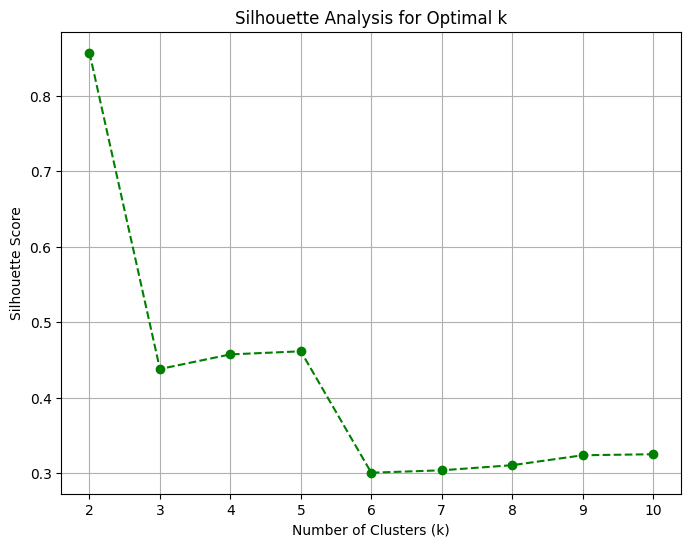

In [25]:
# Define range for k values
k_values = range(2, 11)  # Silhouette score requires at least 2 clusters
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(user_data_pca)
    score = silhouette_score(user_data_pca, cluster_labels)
    silhouette_scores.append(score)

# Identify the best k (highest silhouette score)
best_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {best_k}")

# Plot Silhouette Scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)
plt.show()


Observations:

Best Clustering at k=2 → Highest silhouette score (~0.85), indicating well-defined clusters.

Drop in Score for Higher k → Clusters become less distinct as k increases.

Optimal k Around 4 or 5 → Scores stabilize before declining sharply after k=6.

Low Scores Beyond k=6 → Increasing k further adds complexity without improving cluster quality.